use default res: 0.005988023952095809 meter/pixel
xres: 0.005987261146496815
yres: 0.005982199665026147
The real pose of soanr is 
 x:1.0 
 y:-0.05000004172325134 
 z:2.009999990463257 
 roll:1.1397004127502441 
 pitch:0.03490658849477768 
 yaw:1.5009820461273193


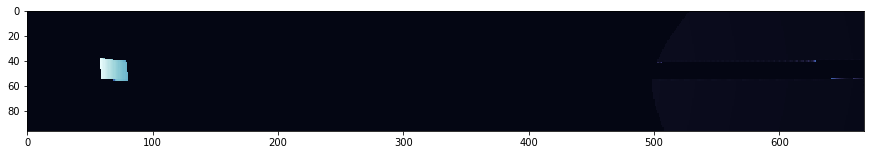

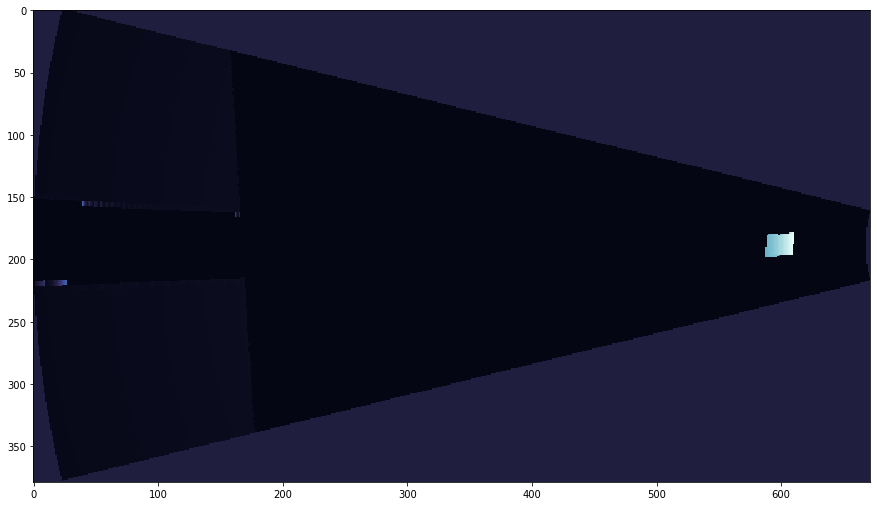

In [1]:
from procSonar import *
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from angle_table import angle_table
from palettable.cmocean.sequential import Ice_20

### 设置参数
rmin = 0.7
rmax = 4.7
nbeams = 96  # ARIS 1800 High Freq
distance_resolution = 0.006
res = (rmax-rmin) / int(np.round((rmax-rmin) / distance_resolution))

### 显示图片的函数

### 读入 polar 图像
polar = imread('./fls/polar0.png', as_gray=True)
plt.figure(figsize=(15, 15))
plt.imshow(polar.transpose(), cmap=Ice_20.mpl_colormap)

### 计算 LUT 并转换
LUT = computeLUT(rmin=rmin, rmax=rmax, angle_table=angle_table, res=None, img=polar)
carte = remap(np.fliplr(polar), LUT, background=30)  # LUT 右至左角度增加，上至下距离增加
plt.figure(figsize=(15, 15))
plt.imshow(carte.transpose(), cmap=Ice_20.mpl_colormap)

### 读入 poses
pose = sio.loadmat('./fls/pose0.mat')
cam_xyz = pose['cam_xyz'][0]
cam_rpy = pose['cam_rpy'][0]
print("The real pose of soanr is \n x:{} \n y:{} \n z:{} \n roll:{} \n pitch:{} \n yaw:{}".format(cam_xyz[0], cam_xyz[1], cam_xyz[2], cam_rpy[0], cam_rpy[1], cam_rpy[2]))


Get 1 contours


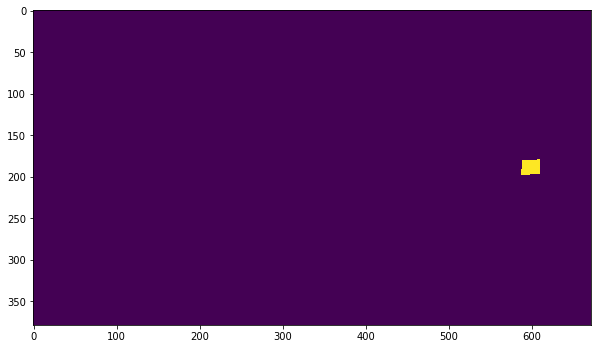

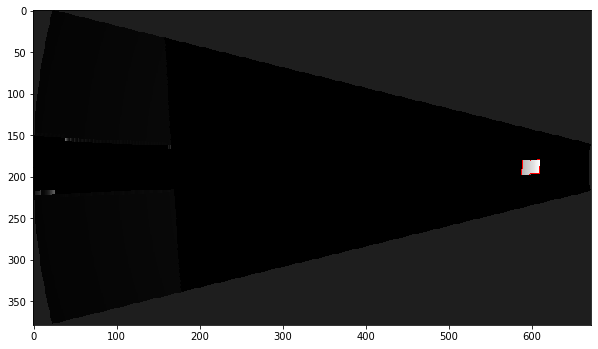

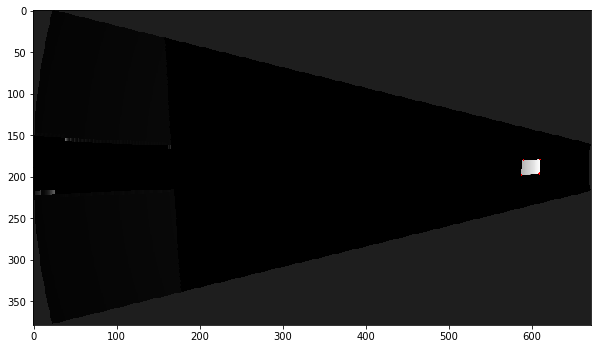

In [2]:
import cv2 as cv

# binary
thres = 125
maxval = 255
_, binary_carte = cv.threshold(carte,thres,maxval,cv.THRESH_BINARY)
plt.figure(figsize=(10, 10))
plt.imshow(binary_carte.transpose())  # better visualization

# find contours
contours, hierarchy = cv.findContours(binary_carte, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
print(f'Get {len(contours)} contours')

# draw contours
img_full_contours = cv.cvtColor(carte,cv.COLOR_GRAY2RGB)
cv.drawContours(img_full_contours, contours, -1, (255,0,0), 1)  # draw all 
plt.figure(figsize=(10, 10))
plt.imshow(img_full_contours.transpose((1,0,2)))  # better visualization

# Douglas-Peucker to simplify lines.
img_approx = cv.cvtColor(carte,cv.COLOR_GRAY2RGB)
is_closed = True
for contour in contours:
    # find convex hull
    convex = cv.convexHull(contour)
    epsilon = 0.02 * cv.arcLength(convex, is_closed)
    approx = cv.approxPolyDP(convex, epsilon, is_closed)
    # cv.drawContours(img_approx, [approx], -1, (255,0,0), 1)  # draw all 
    for p in approx:
        cv.circle(img_approx, p[0], 1, (255,0,0), -1, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_approx.transpose((1,0,2)))  # better visualization

In [9]:
###### 通过 Affinity Photo 手动得到端点的坐标，尝试是否能恢复出声呐的位姿
###### [beam, bin]
ln = np.array([38, 58])
lf = np.array([41, 79])
rn = np.array([54, 59])
rf = np.array([55, 80])

# Convert points in sonar img into 3D coordinates in the center of sonar
# 由于 blender 中 -Z 为朝向 
def polar2rect3D(theta, phi, r):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)
    z = -r*np.cos(phi)*np.cos(theta)
    return np.array([x,y,z])

### 3D coords in sonar
ln_xyz = polar2rect3D(angle_table.ac[ln[0]], np.deg2rad(7),ln[1]*res+rmin)
lf_xyz = polar2rect3D(angle_table.ac[lf[0]], np.deg2rad(-7),lf[1]*res+rmin)
rn_xyz = polar2rect3D(angle_table.ac[rn[0]], np.deg2rad(7),rn[1]*res+rmin)
rf_xyz = polar2rect3D(angle_table.ac[rf[0]], np.deg2rad(-7),rf[1]*res+rmin)

### construct Ax=b
# A: 4x4
A = np.stack([ln_xyz, lf_xyz, rn_xyz, rf_xyz])
A = np.concatenate((A,np.ones([4,1])), axis=1)
# b: 4x2
b = np.array([[0,-0.05],[0,-0.05],
              [0,0.05],[0,0.05]])

### x=(A^-1)b
x = np.linalg.inv(A)@b

### real matrix (Sonar To World)
# extrinsic to intrinsic
cam_rpy_intr = R.from_euler('xyz', cam_rpy).as_euler('XYZ')
rROT = R.from_euler('xyz', cam_rpy).as_matrix()
rt = cam_xyz.reshape(-1, 1)  # [3, 1]
rx = np.concatenate((rROT,rt),axis=-1).transpose()


In [ ]:
###### 通过 Affinity Photo 手动得到端点的坐标，尝试是否能恢复出声呐的位姿
###### [beam, bin]
ln = np.array([24, 553])
lf = np.array([24, 585])
rn = np.array([29, 552])
rf = np.array([29, 585])

# Convert points in sonar img into 3D coordinates in the center of sonar
# 由于 blender 中 -Z 为朝向 
def polar2rect3D(theta, phi, r):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)
    z = -r*np.cos(phi)*np.cos(theta)
    return np.array([x,y,z])

### 3D coords in sonar
ln_xyz = polar2rect3D(angle_table.ac[ln[0]], np.deg2rad(7),ln[1]*res+rmin)
lf_xyz = polar2rect3D(angle_table.ac[lf[0]], np.deg2rad(-7),lf[1]*res+rmin)
rn_xyz = polar2rect3D(angle_table.ac[rn[0]], np.deg2rad(7),rn[1]*res+rmin)
rf_xyz = polar2rect3D(angle_table.ac[rf[0]], np.deg2rad(-7),rf[1]*res+rmin)

### construct Ax=b
# A: 4x4
A = np.stack([ln_xyz, lf_xyz, rn_xyz, rf_xyz])
A = np.concatenate((A,np.ones([4,1])), axis=1)
# b: 4x2
b = np.array([[0,-0.05],[0,-0.05],
              [0,0.05],[0,0.05]])

### x=(A^-1)b
x = np.linalg.inv(A)@b

### real matrix (Sonar To World)
# extrinsic to intrinsic
cam_rpy_intr = R.from_euler('xyz', cam_rpy).as_euler('XYZ')
rROT = R.from_euler('xyz', cam_rpy).as_matrix()
rt = cam_xyz.reshape(-1, 1)  # [3, 1]
rx = np.concatenate((rROT,rt),axis=-1).transpose()


In [ ]:
###### 通过 Affinity Photo 手动得到端点的坐标，尝试是否能恢复出声呐的位姿
###### a b c -> left, center, right.
###### n f -> near, far
###### [beam, bin]
an = np.array([22, 463])
af = np.array([26, 499])
bn = np.array([30, 462])
bf = np.array([44, 500])
cn = np.array([53, 465])
cf = np.array([53, 503])

# Convert points in sonar img into 3D coordinates in the center of sonar
def polar2rect3D(theta, phi, r):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.cos(phi)*np.cos(theta)
    z = r*np.sin(phi)
    return np.array([x,y,z])

### 3D coords in sonar
an_xyz = polar2rect3D(angle_table.ac[an[0]], np.deg2rad(7), an[1]*res+rmin)
af_xyz = polar2rect3D(angle_table.ac[af[0]], np.deg2rad(-7), af[1]*res+rmin)
bn_xyz = polar2rect3D(angle_table.ac[bn[0]], np.deg2rad(7), bn[1]*res+rmin)
bf_xyz = polar2rect3D(angle_table.ac[bf[0]], np.deg2rad(-7), bf[1]*res+rmin)
cn_xyz = polar2rect3D(angle_table.ac[cn[0]], np.deg2rad(7), cn[1]*res+rmin)
cf_xyz = polar2rect3D(angle_table.ac[cf[0]], np.deg2rad(-7), cf[1]*res+rmin)

### real matrix
rROT = R.from_euler('xyz', cam_rpy).as_matrix()
rt = cam_xyz.reshape(-1, 1)  # [3, 1]



### Get 2x4 extended matrix
### R24 = [R11, R12, R13, tx]
###       [R21, R22, R23, ty]
pc = np.matrix([[an_xyz[0], af_xyz[0]]])
print('h')
